# Import

In [93]:
import gym
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete
from gym import spaces
import numpy as np
import random
import os

import pandas as pd
from stable_baselines3 import PPO, DQN, A2C, DDPG
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# Data loading

In [2]:
files = os.listdir("DayCSV")
pd_refs = []
for i in files:
    pd_refs.append(pd.read_csv("DayCSV\\"+i))

# Environment

Following the same environment setup as before, allowing batching in states

In [87]:
class PowerPredEnv(Env):
    def __init__(self):
        self.action_space = Box(low=0, high=63000, shape=(23,)) # Increase, Decrease, keep same
        self.observation_space = Box(low=0, high=63000, shape=(24,)) ## [Power in MW for 24 days]
        self.day = 0 #Current day - Opens the day's CSV file
        self.state = list(pd_refs[self.day]["MW"]) ## State of the environment
        
    def get_next_day_power(self):
        ## Returns the power consumption of the day stored in self.day
        return list(pd_refs[self.day]["MW"])

    def next_day(self):
        ## Randomly changes the day
        self.day += 1
        
    def step(self, action):
        reward = 0
        for i in range(1,len(self.state)):
            prev_power = self.state[i-1] ## Get power at timestep t
            curr_power = self.state[i] ## Get power at timestep t+1
            curr_action = action[i-1] ## Get action for Timestep t
            if(curr_action == 0):
                ## Predicted increase
                if(prev_power < curr_power):
                    ## Correct prediction
                    reward += 10
                else:
                    ## Incorrect prediction
                    reward -= 100
            elif (curr_action==1):
                ## Predicted decrease
                if(prev_power > curr_power):
                    ## Correct prediction
                    reward += 10
                else:
                    ## Incorrect prediction
                    reward -= 100
            else:
                ## Predict constant power
                if(0.95 * prev_power <= curr_power <= 1.05 * prev_power):
                    ## Correct prediction
                    ## Next day power within 5%
                    reward+=10
                else:
                    reward -= 100
        
        info = {
            "day":self.day+1,
            "reward":reward,
            "predicted":action,
            "input_state":self.state
        }

        self.next_day() ## Change the day
        done = False
        if(self.day == 30):
            done = True
        else:
            self.state = self.get_next_day_power()
        return self.state, reward, False, done, info
    
    def render(self):
        pass
    
    def reset(self):
        ## Reset the values
        self.day = 0 # Reset day
        self.state = list(pd_refs[self.day]["MW"]) ## Get power consumption on that day
        info = {
            "day":self.day+1,
            "input_state":self.state
        }
        return self.state, info

# Training

In [88]:
env = PowerPredEnv()

# Random episodes

In [89]:
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    
    while not done:
        env.render()
        action = env.action_space.sample()
        n_state, reward, _, done, info = env.step(action)
        score += reward
        # if(reward > 0):
        #     print(reward, info)
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

Episode:1 Score:-17630
Episode:2 Score:-17630
Episode:3 Score:-17630
Episode:4 Score:-17630
Episode:5 Score:-17630


## Training

In [90]:
log_path = os.path.join('Training', 'logs')

## PPO

In [91]:
model1 = PPO('MlpPolicy', env, verbose=1, tensorboard_log = log_path)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [92]:
model1.learn(total_timesteps=500000)

Logging to Training\logs\PPO_14
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 30        |
|    ep_rew_mean     | -2.58e+04 |
| time/              |           |
|    fps             | 526       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 30          |
|    ep_rew_mean          | -2.54e+04   |
| time/                   |             |
|    fps                  | 394         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008523667 |
|    clip_fraction        | 0.0727      |
|    clip_range           | 0.2         |
|    entropy_loss         | -32.6       |
|    explained_variance   | 5.

PPO

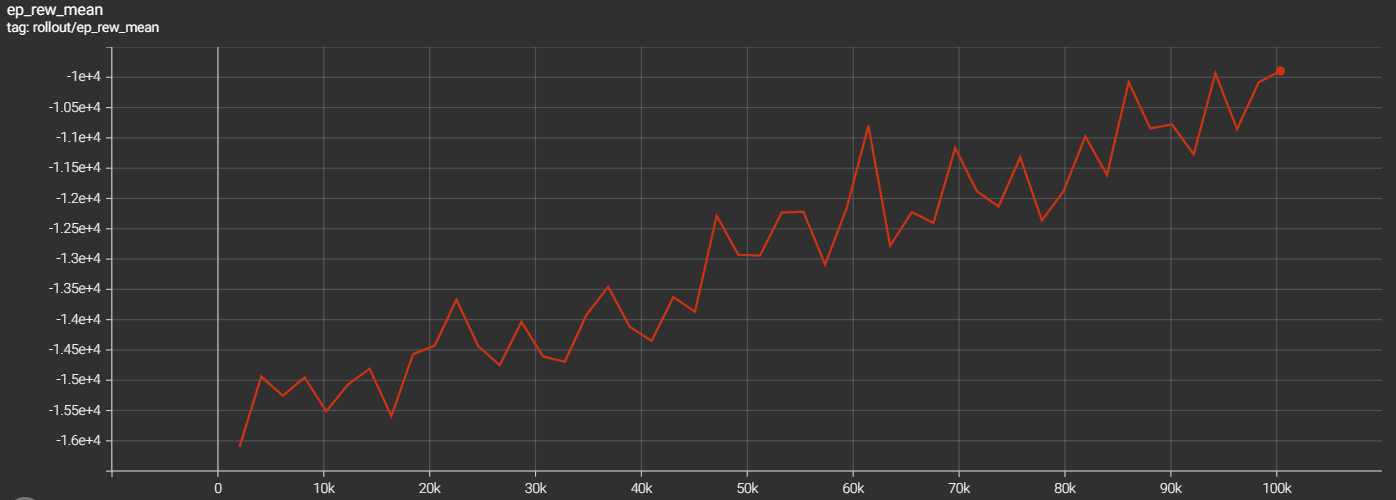

After training for 100,000 timesteps, average reward = - 9890

After further training for a total of 600,000 timesteps, average reward = - 8070

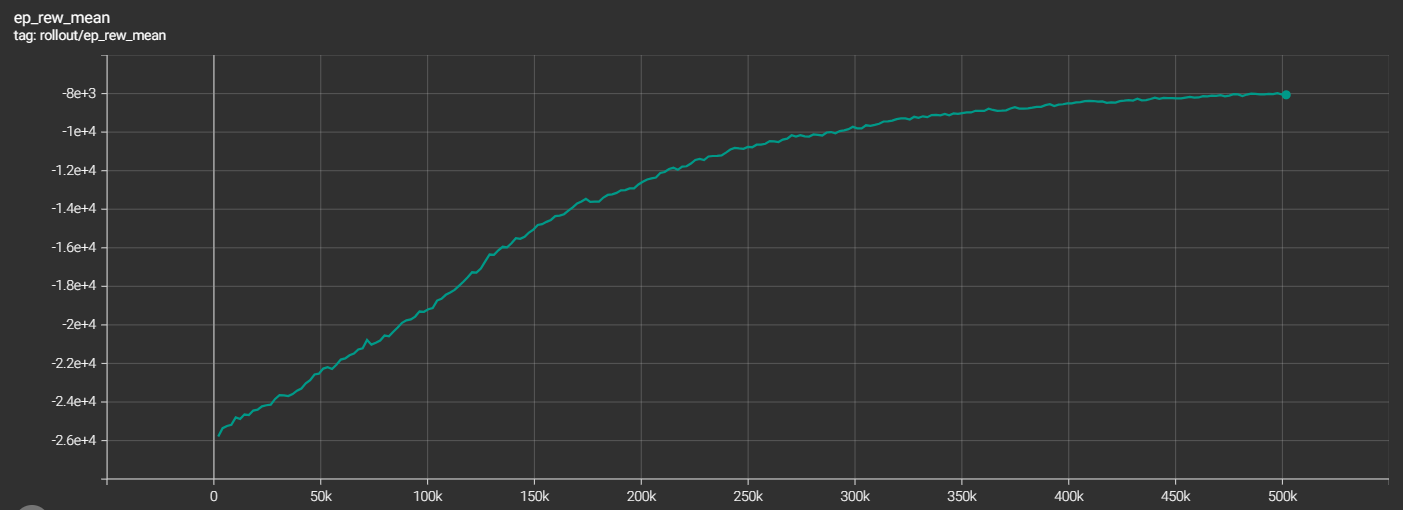

The algorithm starts converging around average reward of -8070

Approximately, it denotes choosing wrong actions on 80 actions out of approximately 720 actions, denoting an accuracy of about 88%

## DQN is not used as it does not support Box datatype for action space

## DDPG

In [94]:
model2 = DDPG('MlpPolicy', env, verbose=1, tensorboard_log = log_path)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [95]:
model2.learn(total_timesteps=100000)

Logging to Training\logs\DDPG_1
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 30        |
|    ep_rew_mean     | -1.87e+04 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 649       |
|    time_elapsed    | 0         |
|    total_timesteps | 120       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 30        |
|    ep_rew_mean     | -2.12e+04 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 170       |
|    time_elapsed    | 1         |
|    total_timesteps | 240       |
| train/             |           |
|    actor_loss      | 267       |
|    critic_loss     | 4.99e+04  |
|    learning_rate   | 0.001     |
|    n_updates       | 120       |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 

DDPG
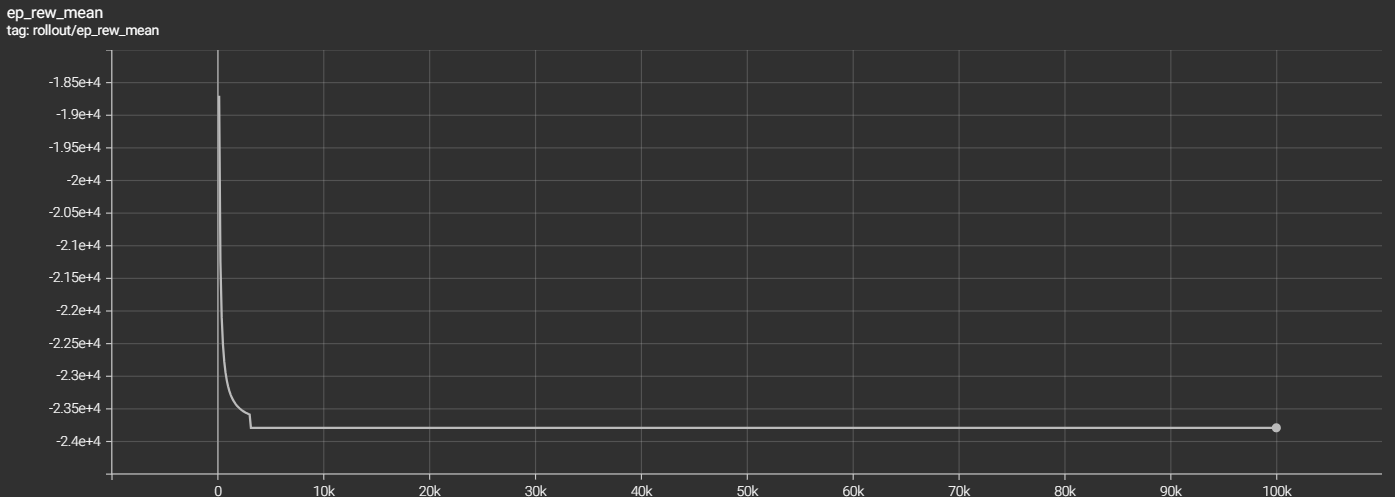
Average reward after 100,000 timesteps = -23800

The algorithm stagnates and does not improve in performance

## A2C

In [96]:
model3 = A2C('MlpPolicy', env, verbose=1, tensorboard_log = log_path)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [99]:
model3.learn(total_timesteps=500000)

Logging to Training\logs\A2C_9
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 30        |
|    ep_rew_mean        | -1.19e+04 |
| time/                 |           |
|    fps                | 218       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -38.5     |
|    explained_variance | 5.96e-08  |
|    learning_rate      | 0.0007    |
|    n_updates          | 20099     |
|    policy_loss        | -5.5e+04  |
|    std                | 1.3       |
|    value_loss         | 2.59e+06  |
-------------------------------------
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 30        |
|    ep_rew_mean        | -1.23e+04 |
| time/                 |           |
|    fps                | 241       |
|    iterations         | 200       |
|    time_elapsed  

A2C

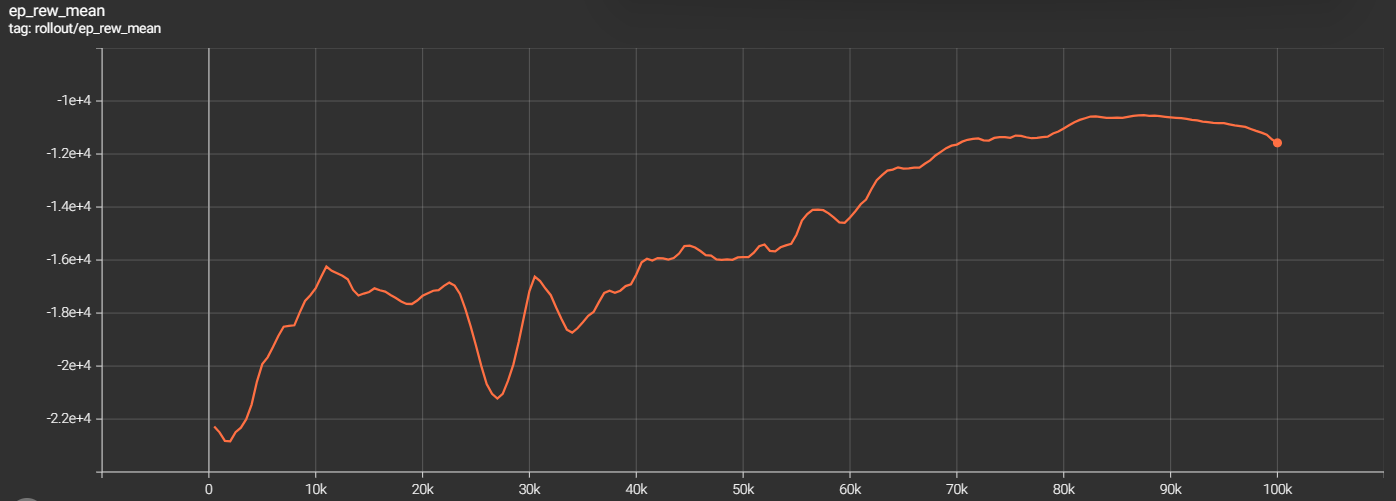

After training for 100,000 timesteps, average reward = -11600  (Accuracy of about 84%)



Further training to a toal of 500,00 timesteps, average reward = -7960 (Accuracy of about 89%)

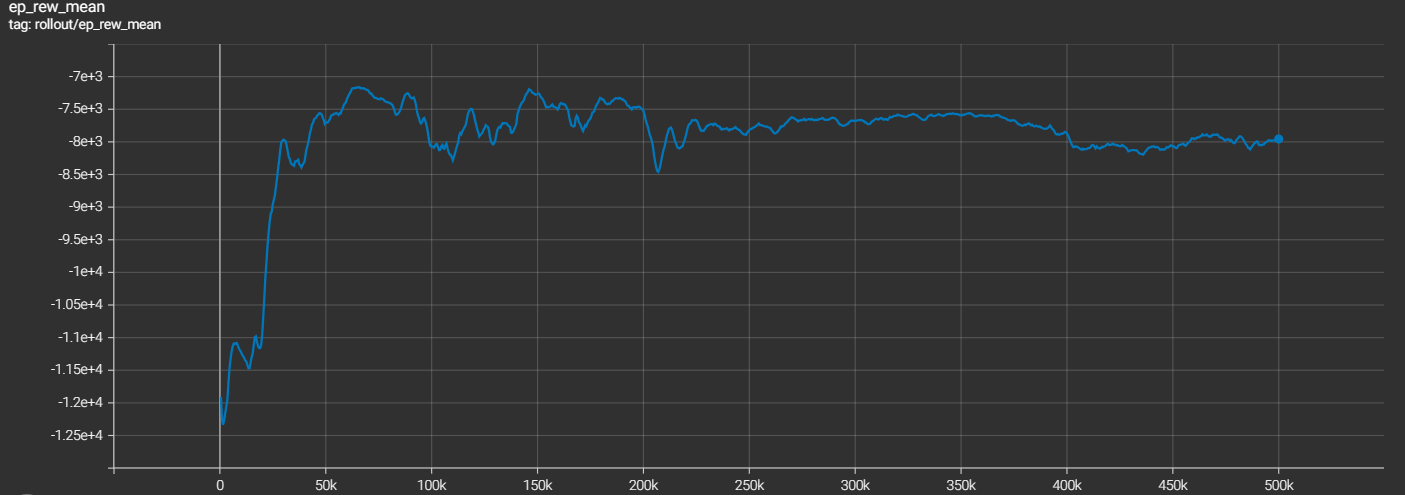

The A2C algorithm reaches convergence around reward of -7960 

## Comparison

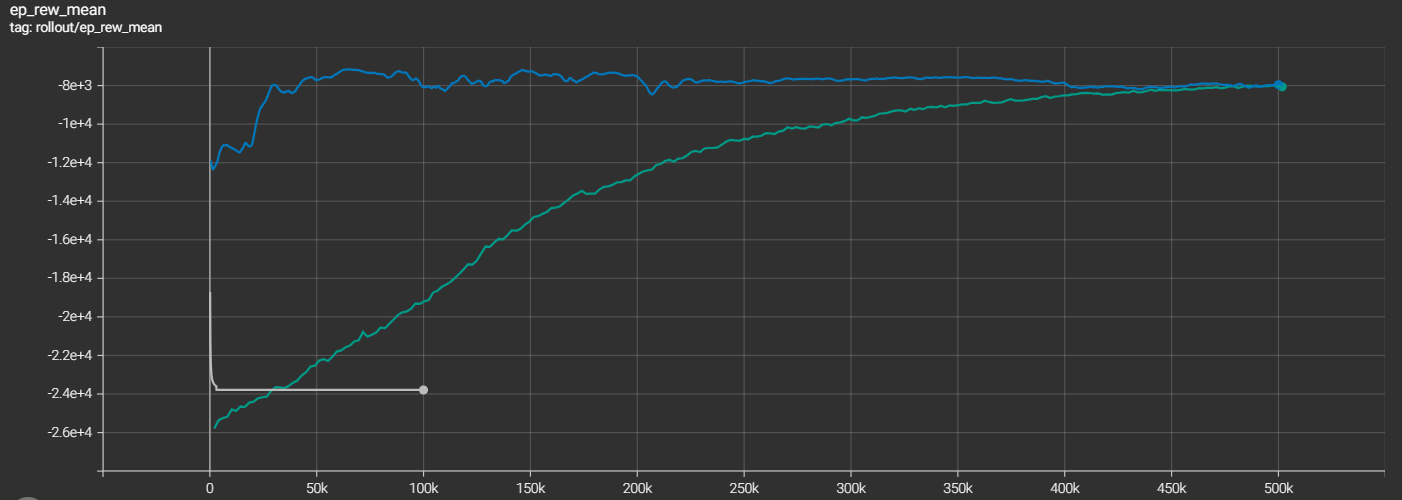

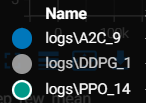

The algorithms PPO and A2C are able to learn from the environment and demonstrate performance improvement. The DDPG algorithm was not able to learn and its average reward remained constant.

## Conclusion

By applying batching, the algorithms are able to work on the entire data and perform actions. Comparing it to the results of Environments 1 and 2, the batching demonstrates a higher accuracy for the objective. 

Further improvement in the model can be done by using different models, editing the reward functions and training for higher number of epochs.